In [1]:
import pandas as pd
import json
import requests
import datetime
from sqlalchemy import create_engine
import psycopg2
#postgres_url_user_pass = "user:pass"
#postgres_server = "127.0.0.1"
from config import postgres_url_user_pass
from config import postgres_server

In [2]:
#URL found from viewing web inspector in web browser to find the current list of issues
url = "https://seeclickfix.com/api/v2/issues?min_lat=39.03211937423035&min_lng=-95.71889877319336&max_lat=39.052118348329074&max_lng=-95.6312656402588&status=open%2Cacknowledged%2Cclosed&fields%5Bissue%5D=id%2Csummary%2Cdescription%2Cstatus%2Clat%2Clng%2Caddress%2Cmedia%2Ccreated_at%2Cacknowledged_at%2Cclosed_at&page=1"

In [3]:
#grab an initial response to grab the total number of pages
response = requests.get(url).json()
total_pages = response['metadata']['pagination']['pages']

In [4]:
#define a function to get urls from the initial URL 
def get_issues(url):
    #create a temp list for all issues to return
    all_issues = []
    for i in range(1,total_pages +1):
        print(f"getting page {i} of {total_pages}")
        response = requests.get(url).json()
        next_page_url = response['metadata']['pagination']['next_page_url']
        page_issues = response['issues']
        #add current list of issues to the existing list of issues
        all_issues.extend(page_issues)
        #set URL to next page to get the next set of issues
        url = next_page_url
    #return the list of all issues
    return all_issues

In [5]:
# call function to get all issues
all_issues = get_issues(url)

getting page 1 of 18
getting page 2 of 18
getting page 3 of 18
getting page 4 of 18
getting page 5 of 18
getting page 6 of 18
getting page 7 of 18
getting page 8 of 18
getting page 9 of 18
getting page 10 of 18
getting page 11 of 18
getting page 12 of 18
getting page 13 of 18
getting page 14 of 18
getting page 15 of 18
getting page 16 of 18
getting page 17 of 18
getting page 18 of 18


In [6]:
#create dataframe from issue list
issues_df = pd.DataFrame(all_issues)
#set index to the issues id
issues_df = issues_df.set_index('id')

In [7]:
def clean_summary(df):
    #convert dates
    df['created_at'] = pd.to_datetime(
        df['created_at'], format="%Y/%m/%d", utc=True)
    df['acknowledged_at'] = pd.to_datetime(
        df['acknowledged_at'], format="%Y/%m/%d", utc=True)
    df['closed_at'] = pd.to_datetime(
        df['closed_at'], format="%Y/%m/%d", utc=True)
    # calculate time to acknowledge
    df['time to acknowledge'] = df['acknowledged_at'] - df['created_at']
    df['time to close'] = df['closed_at'] - df['created_at']
    
    #return daframe and replace known errant values
    return df.replace({"Curb and Gutter": "Curb and Gutter Repair",
                       "Junk Yard?": "Property Maintenance & Code Violations",
                       "skatepark light": "safety lighting",
                       "Dead animal on sidewalk ": "Police Animal Control",
                       "Loud pedestrian crossing ": "Street Sign Repair",
                       "Pothole": "Street Repair"})


In [8]:
# call function to clean the summary column
issues_df = clean_summary(issues_df)

In [9]:
status_list = issues_df['status'].value_counts()

In [10]:
summary_list = issues_df['summary'].value_counts()
summary_list

Property Maintenance, Code Violations & Graffiti                  140
Curb and Gutter Repair                                             43
Trees and Tree Limbs                                               25
Sidewalk and Ramp                                                  25
Street Repair                                                      22
Police General Issue                                               22
Alley                                                              18
Property Maintenance & Code Violations                             13
Other                                                              12
General Feedback or Questions                                       7
Utility Work Damage                                                 5
safety lighting                                                     2
Street Sign Repair                                                  2
Downtown Parking General Question                                   2
Parking area        

In [11]:
summary_df = pd.DataFrame(issues_df.groupby('summary')['status'].count())

<AxesSubplot:xlabel='summary'>

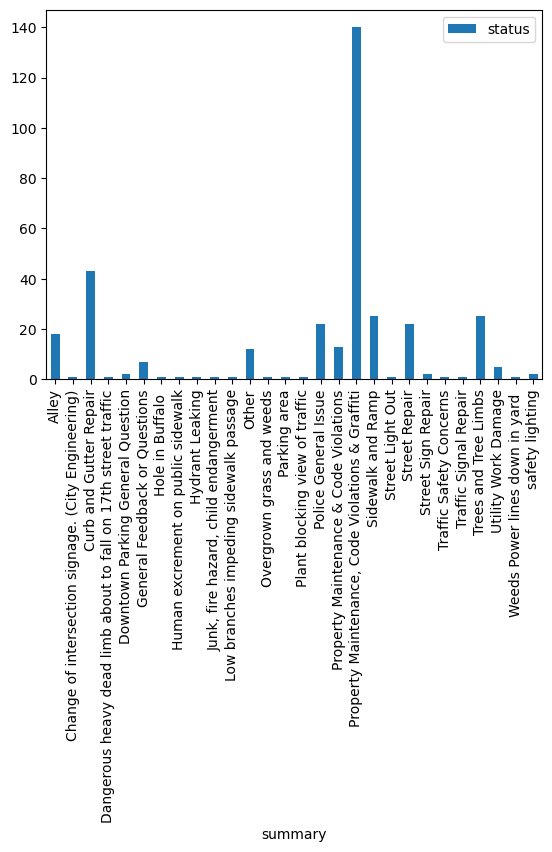

In [12]:
summary_df.plot(kind="bar")

<AxesSubplot:xlabel='status'>

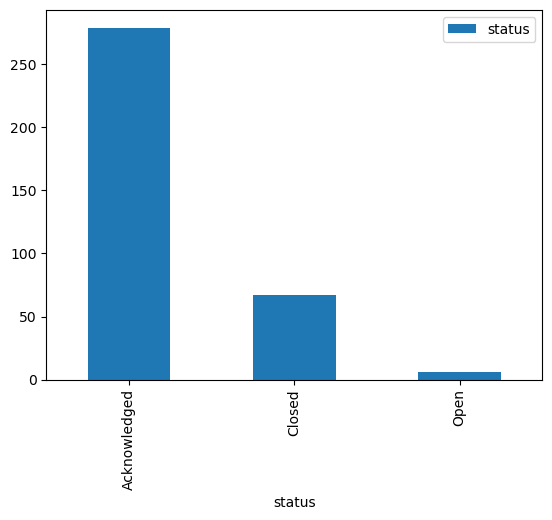

In [13]:
status = pd.DataFrame(issues_df.groupby('status')['status'].count())
status.plot(kind="bar")

In [14]:
issues_df['time to acknowledge']

id
15283992   0 days 00:00:04
15280278   0 days 00:00:21
15279961   0 days 00:00:19
15277027   0 days 00:00:19
15274428   0 days 00:00:12
                 ...      
6044425    0 days 00:00:10
4541947    0 days 00:00:39
4536562    0 days 00:00:32
3462380    0 days 00:07:39
3400442    6 days 04:11:23
Name: time to acknowledge, Length: 352, dtype: timedelta64[ns]

In [15]:
issues_df.groupby('time to acknowledge')['time to acknowledge'].count()

time to acknowledge
0 days 00:00:02     3
0 days 00:00:03    58
0 days 00:00:04    69
0 days 00:00:05    50
0 days 00:00:06    13
                   ..
6 days 04:11:23     1
6 days 17:03:10     1
7 days 19:39:49     1
7 days 19:42:50     1
9 days 04:40:31     1
Name: time to acknowledge, Length: 70, dtype: int64

In [16]:
#save to CSV, in case you want to
issues_df.to_csv("all_issues.csv")

In [17]:
#CREATE TABLE public.test
#(
#    test integer
#);


In [18]:
#using code to create SQL code
print("create table issues_import_test (")
for col in issues_df.columns:
    print(f'"{col}" text,')
print(");")

create table issues_import_test (
"status" text,
"summary" text,
"description" text,
"lat" text,
"lng" text,
"address" text,
"created_at" text,
"acknowledged_at" text,
"closed_at" text,
"url" text,
"media" text,
"time to acknowledge" text,
"time to close" text,
);


# Let's rock this out to the DB and go from there

In [19]:
engine = create_engine(
    f'postgresql+psycopg2://{postgres_url_user_pass}@{postgres_server}/seeclickfix', echo=False)

In [20]:
#remove problem desc column and media column
issues_df= issues_df[['status', 'summary', 'lat', 'lng', 'address',
       'created_at', 'acknowledged_at', 'closed_at', 'url',
       'time to acknowledge', 'time to close']]


In [21]:
issues_df.to_sql('seeClickFixExport',engine,if_exists="replace")

/tmp/ipykernel_2980784/1006464765.py:1: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  issues_df.to_sql('seeClickFixExport',engine,if_exists="replace")


352

In [22]:
cleaned_df =pd.read_sql('select * from "seeClickFixExport"', engine)

In [23]:
cleaned_df.dtypes

id                                   int64
status                              object
summary                             object
lat                                float64
lng                                float64
address                             object
created_at             datetime64[ns, UTC]
acknowledged_at        datetime64[ns, UTC]
closed_at              datetime64[ns, UTC]
url                                 object
time to acknowledge                  int64
time to close                        int64
dtype: object

In [24]:
def findType(df, column):
    if (df.dtypes[column]=='float64' ):
        return 'float'
    #issues_df.dtypes['lat'] == 'float64'
    return "text"

In [26]:
issues_df.dtypes['lat'] == 'float64'

True

In [27]:
#using code to create SQL code
print("create table issues_import_test (")
for col in issues_df.columns:
    print(f'"{col}" {findType(issues_df,col)},')
print(");")

create table issues_import_test (
"status" text,
"summary" text,
"lat" float,
"lng" float,
"address" text,
"created_at" text,
"acknowledged_at" text,
"closed_at" text,
"url" text,
"time to acknowledge" text,
"time to close" text,
);
